# Obtain MOR18-2 spectrum from factorization

In [1]:
#import sys
#sys.path.append('/home/jan/Dokumente/Code/FUImaging/')

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os, glob, json, pickle, csv
import scipy.stats
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from collections import defaultdict
from PIL import Image
from sklearn.isotonic import IsotonicRegression

import regnmf.ImageAnalysisComponents as ia
from ModeSelector import AssignMode

### Specify parameter

In [3]:
stim_window = (8,12) #(3,5) 

#method mask for components to be used. Use string with files to be opened. Use wildmark '*' for changing values.
method =  'nnmf_20_sm5_convex_negTimelowSP_sp*_sph_meas' #'sica_200_ios_meas' #

# datalocations [if you use the standard scheme, only modify basepath]
basepath = os.path.realpath('../glomcentric_data_preprocessed')
data_location = os.path.join(basepath, 'MOBdecomposed')
bg_location = os.path.join(basepath, 'MOBconverted')
aliasfile = os.path.join(basepath, 'DataDicts', 'alias_sph.json')
datadict_path = os.path.join(basepath, 'DataDicts')
savepath182modes = os.path.join(basepath, 'Vis', 'MOR18-2modes')
mor182specSPH_file = os.path.join(basepath, 'DataDicts', 'MOR18-2spec_sph.json')
mor182specIOS_file = os.path.join(basepath, 'DataDicts', 'MOR18-2spec.json')

savepath182spec = os.path.join(basepath, 'Vis', 'MOR18-2spec')

In [4]:
animals = [a for a in os.listdir(data_location) if 'FRV' in a]

Load or create dictionary with mode label (alias).

In [5]:
if os.path.exists(aliasfile):
    alias_dict = json.load(open(aliasfile))
    print("Using previously populated alias file. Contains keys:")
    for k in alias_dict.keys(): 
        print(k)
else:
    alias_dict = {}
if method not in alias_dict:
    alias_dict[method]={}
else:
    print("WARNING: assigning modes will overwrite previous assignments for method\n{}".format(method))

Using previously populated alias file. Contains keys:
nnmf_20_sm5_convex_negTimelowSP_sp*_sph_meas
nnmf_50_sm2_convex_negTimelowSP_sp*_sph_meas
nnmf_20_sm5_convex_negTimelowSP_sp*_sph_meas


### GUI to manually assign MOR18-2 mode

The following step is not necessary for replication of the figure. Please skip unless you know what you're doing. 

If for some reason you would like to revisit the assignment of MOR18-2 modes, we have prepared a GUI to simplify this process. Please note that you have to disable matplotlib's `inline` mode for this to work. 

Left panel shows all extracted modes (blue modes with high stimulus correlation >0.5, grey all others). Right panel shows currently selected mode. Press any pixel to select the mode, most strongly participation in this pixel. Hit button to mark current mode as MOR18-2 mode (becomes red-yellow).

Note: The ROIs extracted from the z-stacks are organized in the way, that MOR18-2 glomeruli are oultined first. That is the first ROI in the rois file is always a MOR18-2 glomerulus and sometimes the second, too. Therefore the first ROI is drawn in red and the second in magenta. Compare with the post-mortem sph stacks to identify if which should be selected.

assign modes for method
nnmf_20_sm5_convex_negTimelowSP_sp*_sph_meas
['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120216FRVb/nnmf_20_sm5_convex_negTimelowSP_sp01_sph_meas.npy']


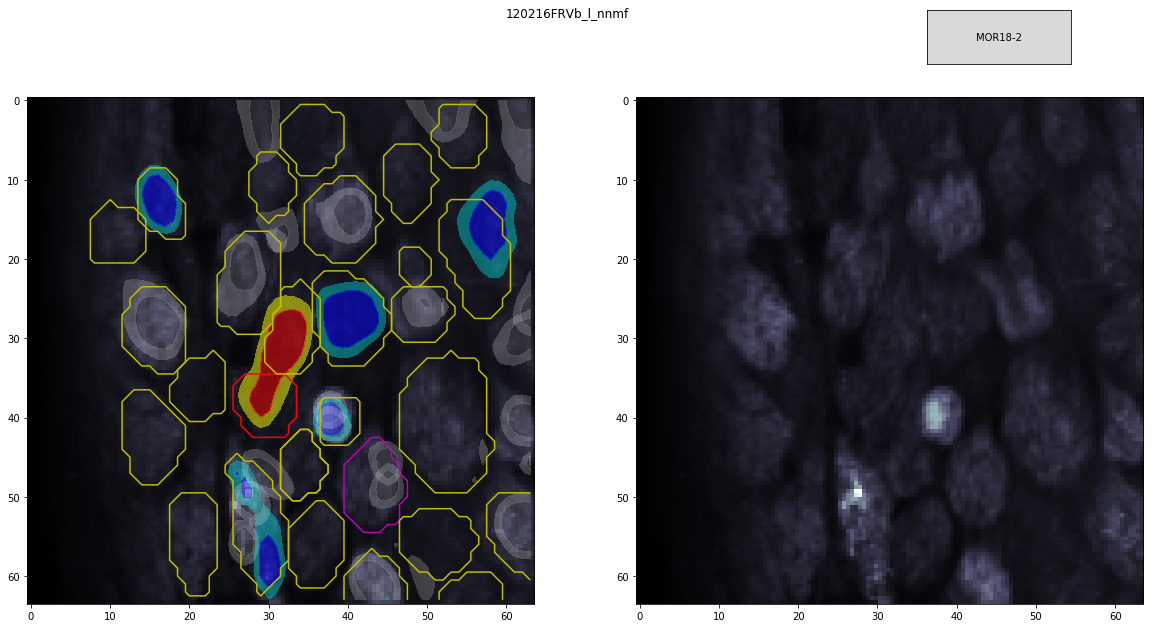

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120217FRVg/nnmf_20_sm5_convex_negTimelowSP_sp02_sph_meas.npy']


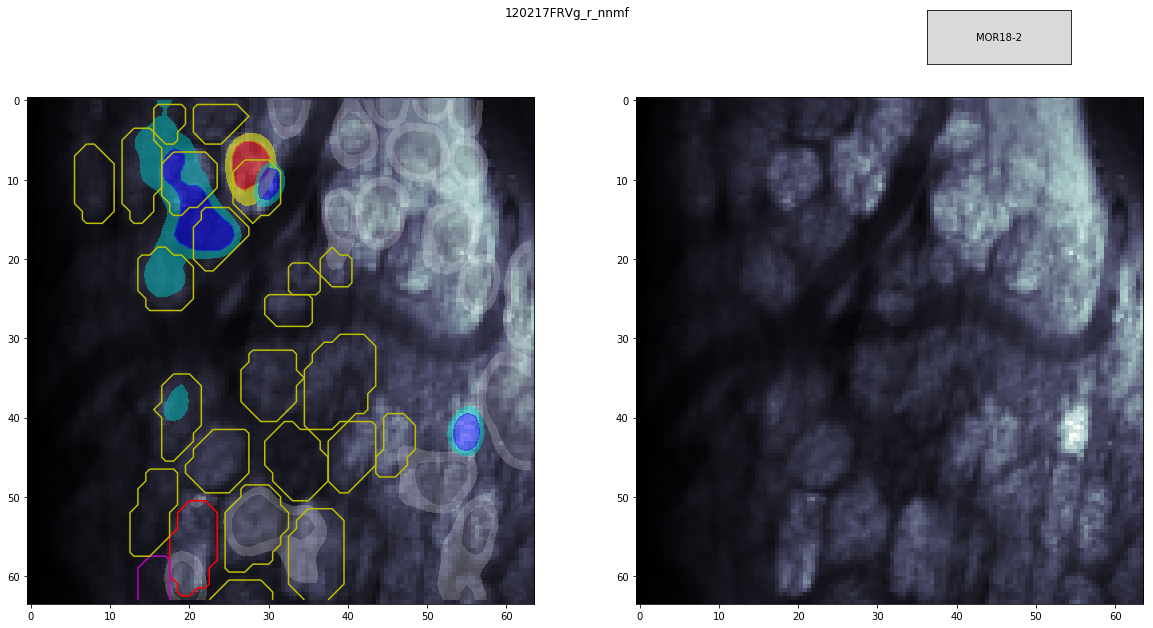

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120221FRVg/nnmf_20_sm5_convex_negTimelowSP_sp01_sph_meas.npy']


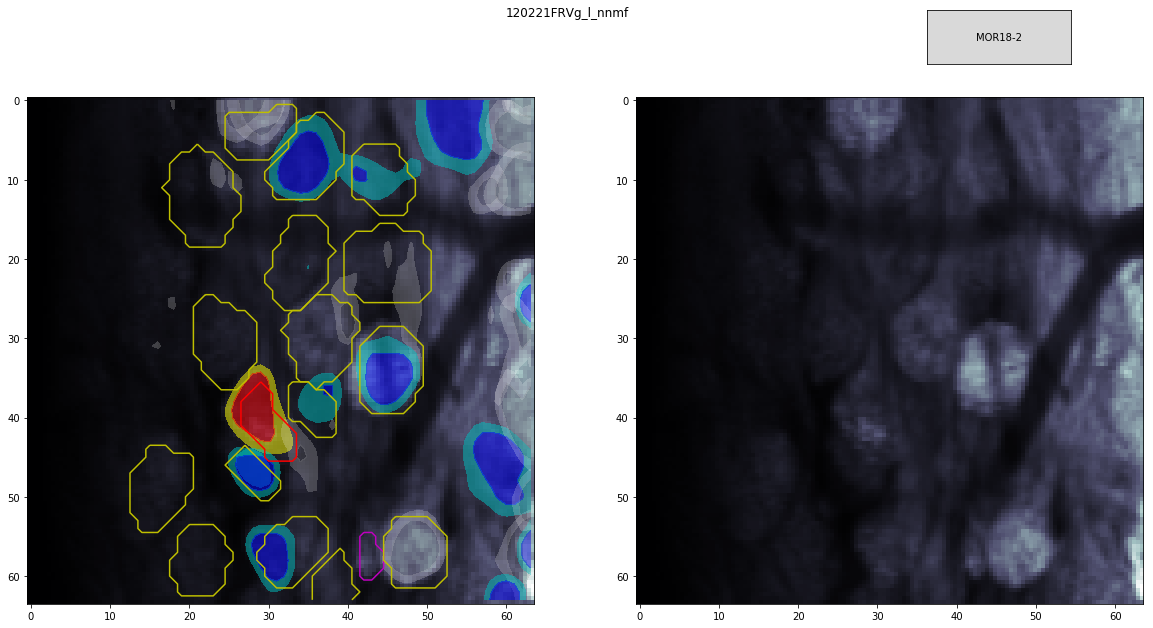

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120222FRV/nnmf_20_sm5_convex_negTimelowSP_sp03_sph_meas.npy']


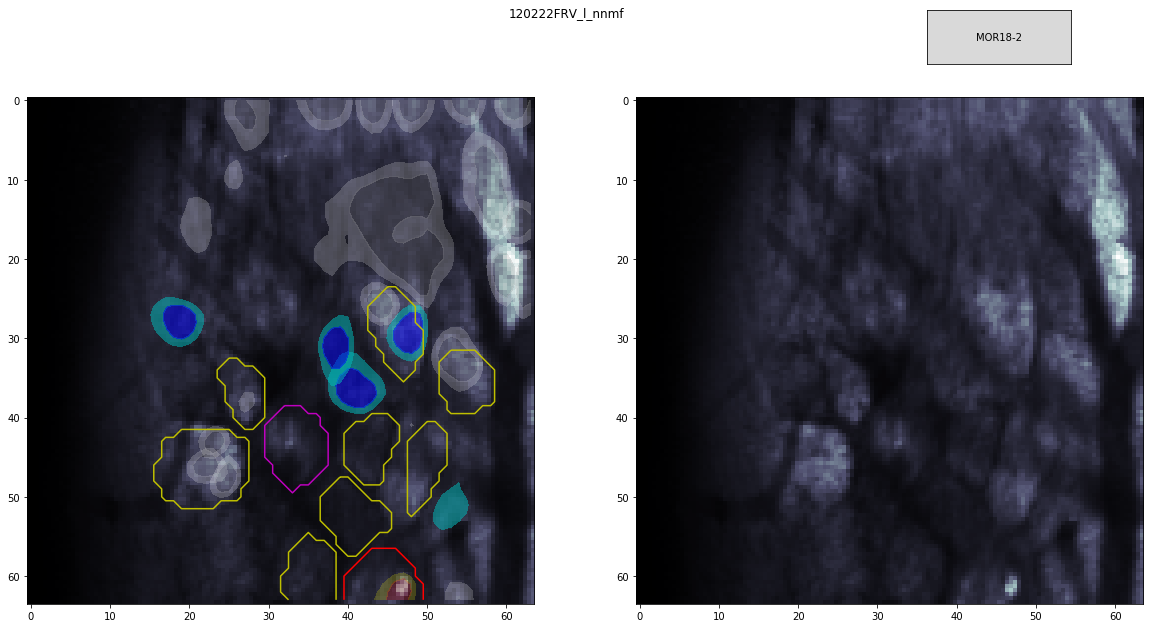

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120223FRV/nnmf_20_sm5_convex_negTimelowSP_sp01_sph_meas.npy']


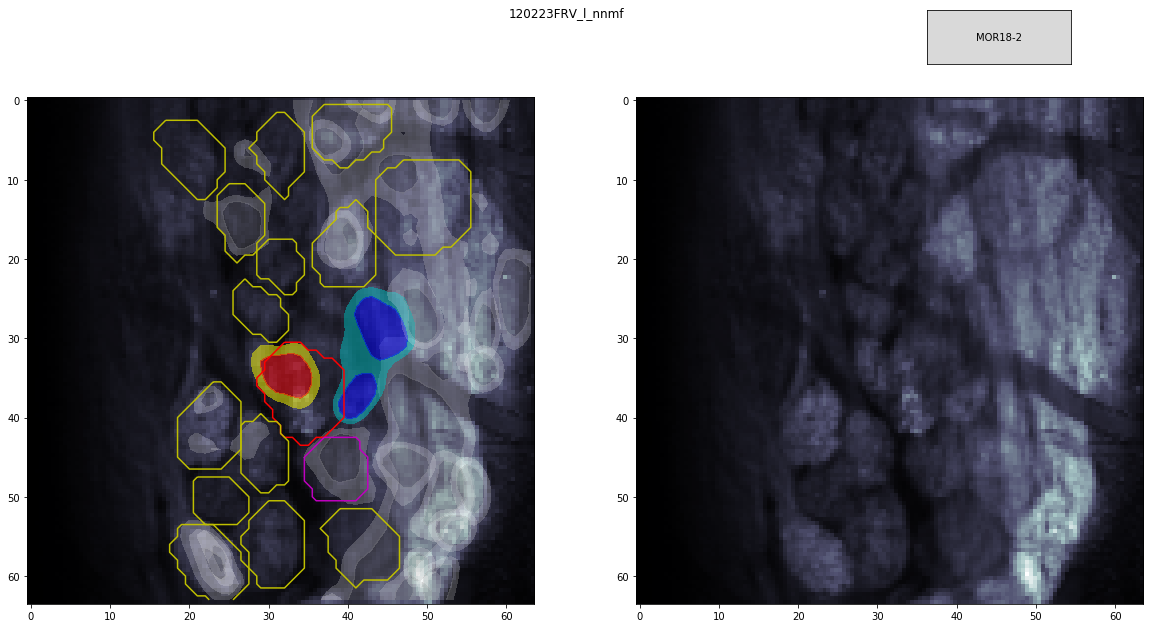

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120224FRVg/nnmf_20_sm5_convex_negTimelowSP_sp03_sph_meas.npy']


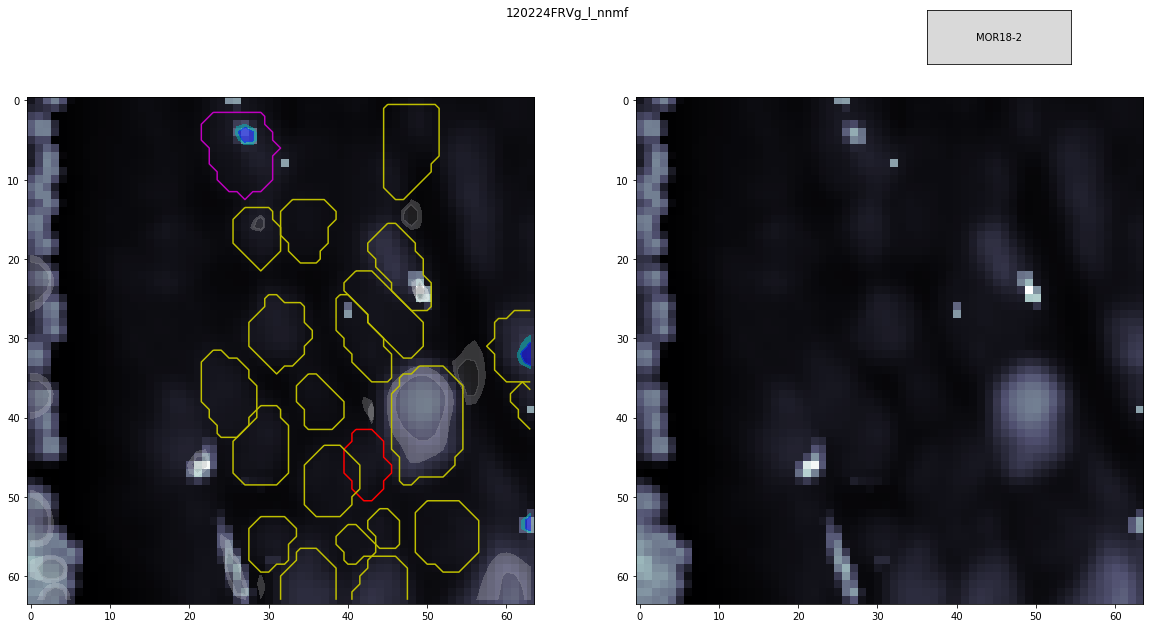

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120306FRV/nnmf_20_sm5_convex_negTimelowSP_sp01_sph_meas.npy']


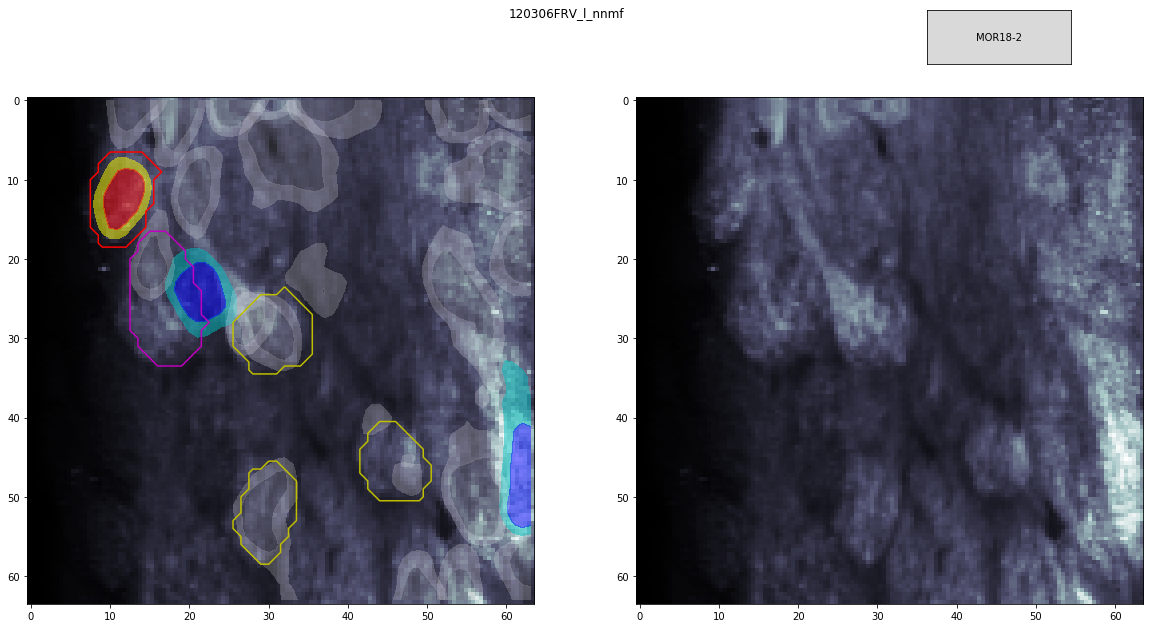

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120307FRV/nnmf_20_sm5_convex_negTimelowSP_sp02_sph_meas.npy']


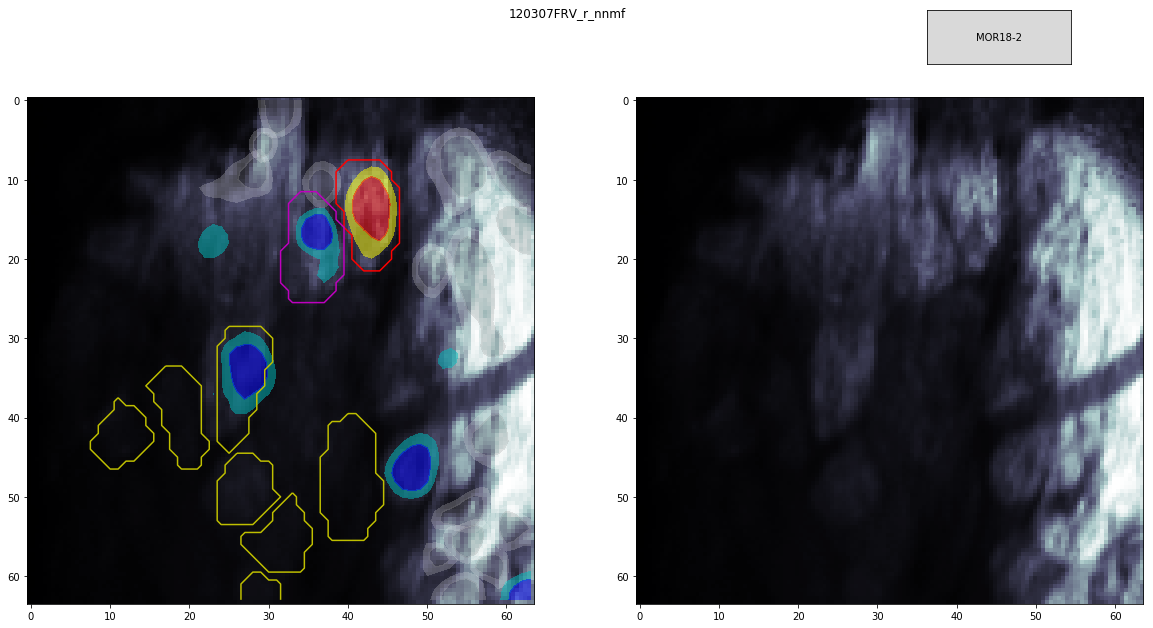

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120309FRV/nnmf_20_sm5_convex_negTimelowSP_sp01_sph_meas.npy']


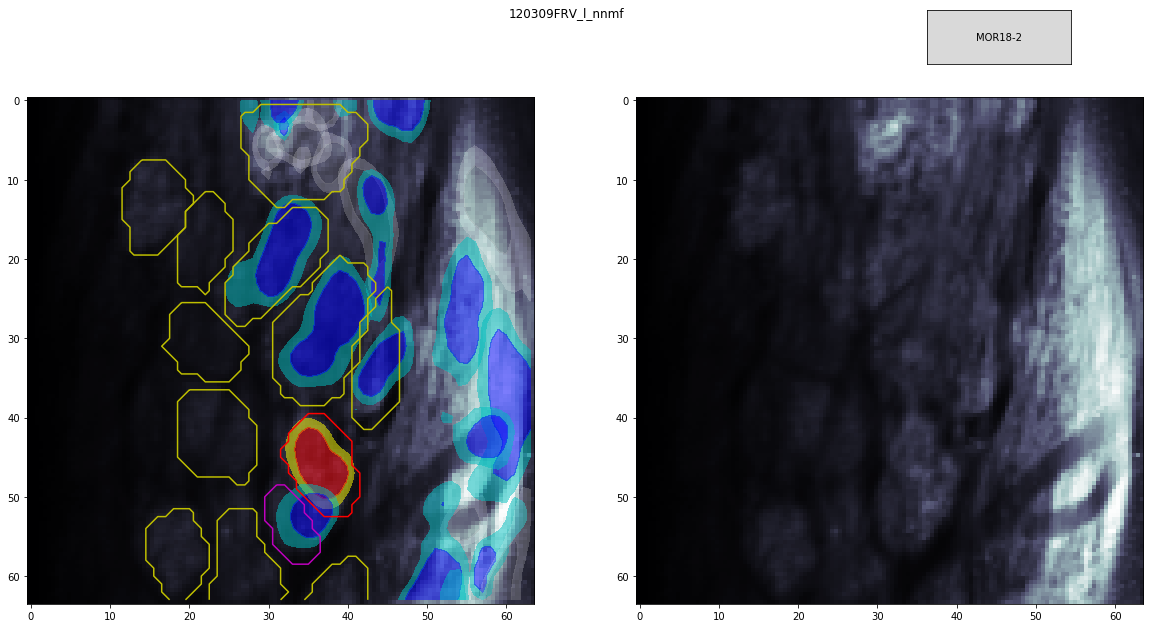

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120311FRVi/nnmf_20_sm5_convex_negTimelowSP_sp04_sph_meas.npy']


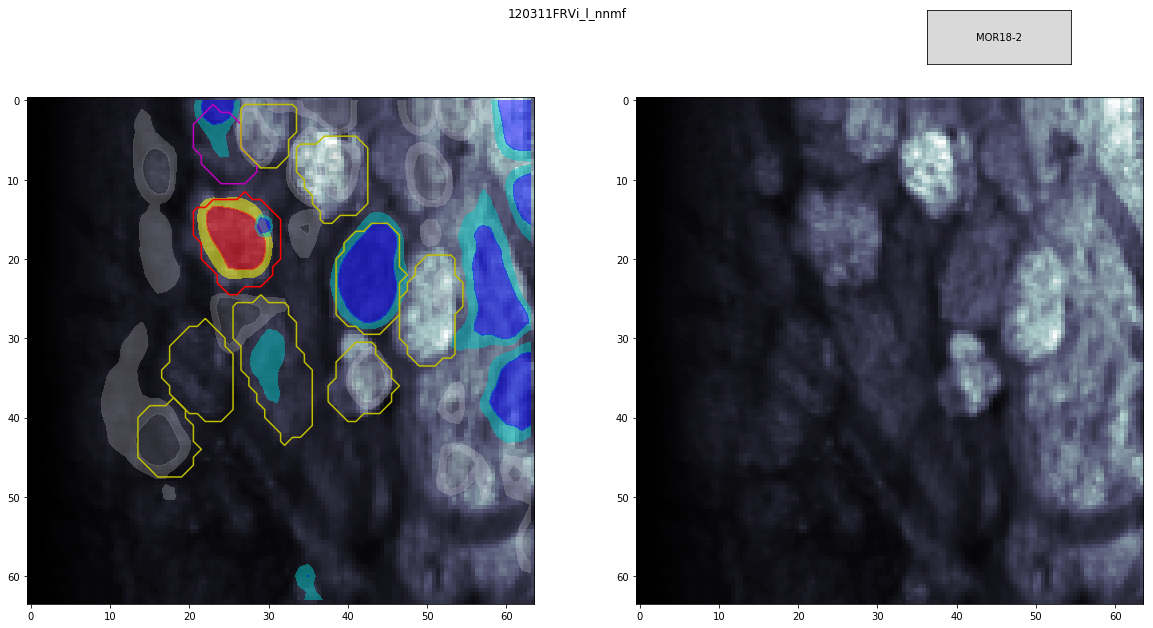

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120314FRV/nnmf_20_sm5_convex_negTimelowSP_sp01_sph_meas.npy']


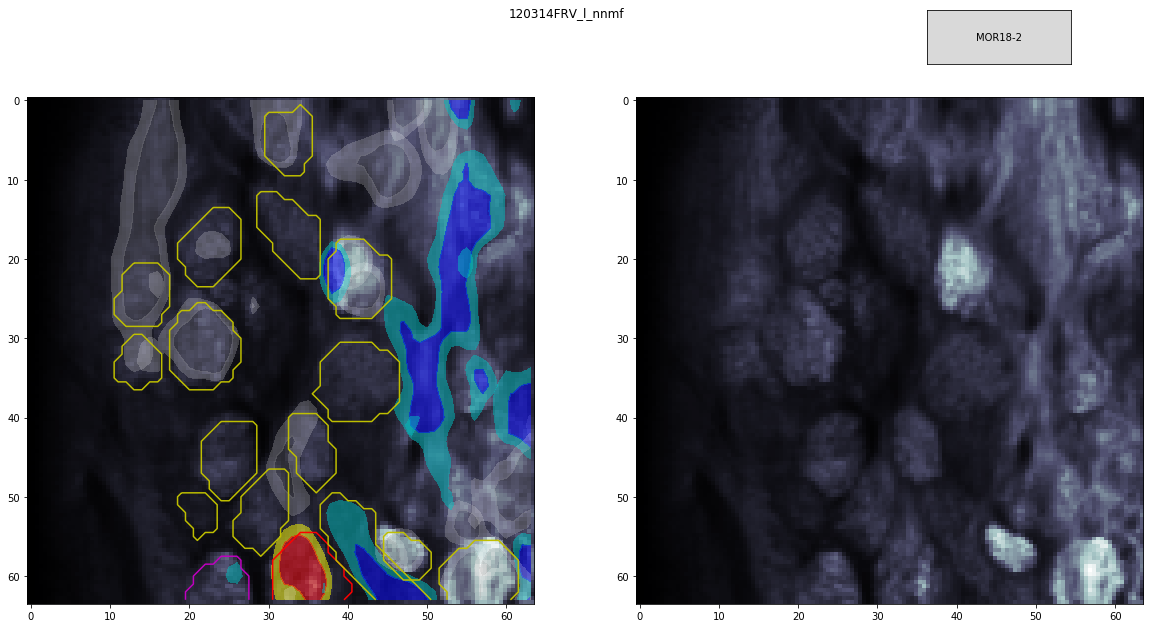

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120315FRV/nnmf_20_sm5_convex_negTimelowSP_sp03_sph_meas.npy']


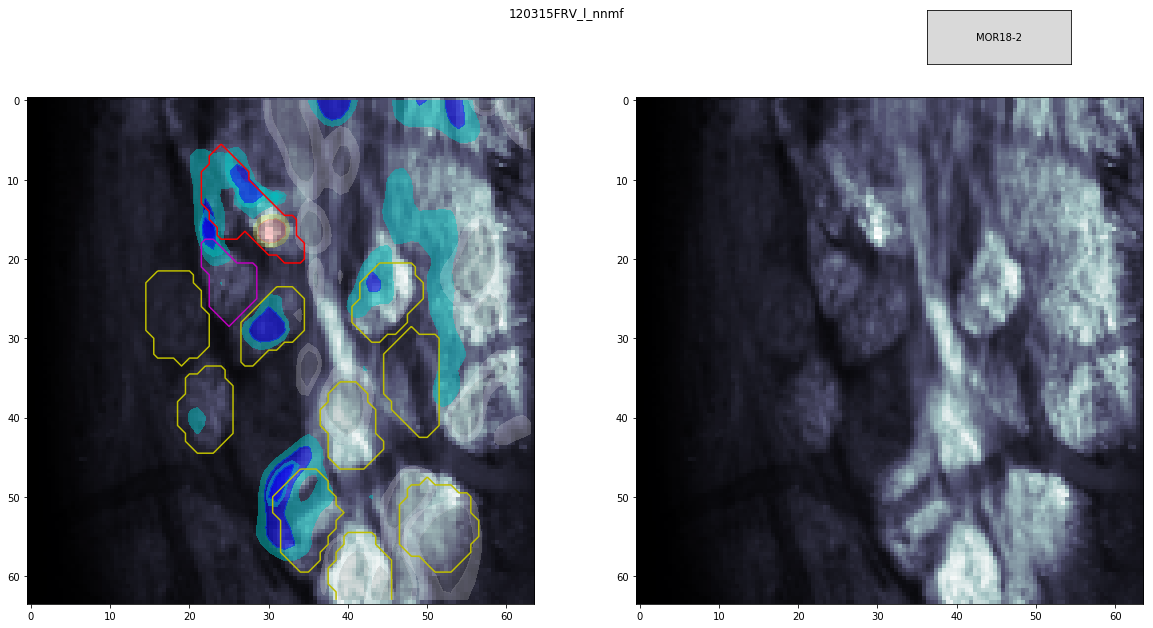

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120325FRVil/nnmf_20_sm5_convex_negTimelowSP_sp02_sph_meas.npy']


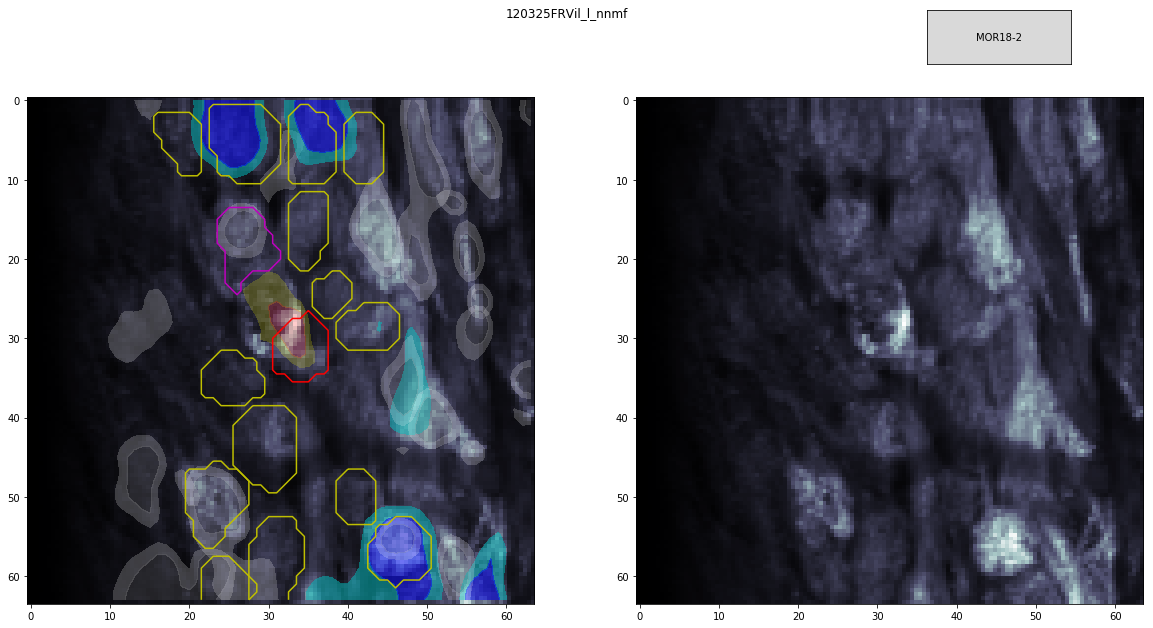

['/BlackHole/ResearchData/MOL23/glomcentric_data_preprocessed/MOBdecomposed/120326FRV/nnmf_20_sm5_convex_negTimelowSP_sp01_sph_meas.npy']


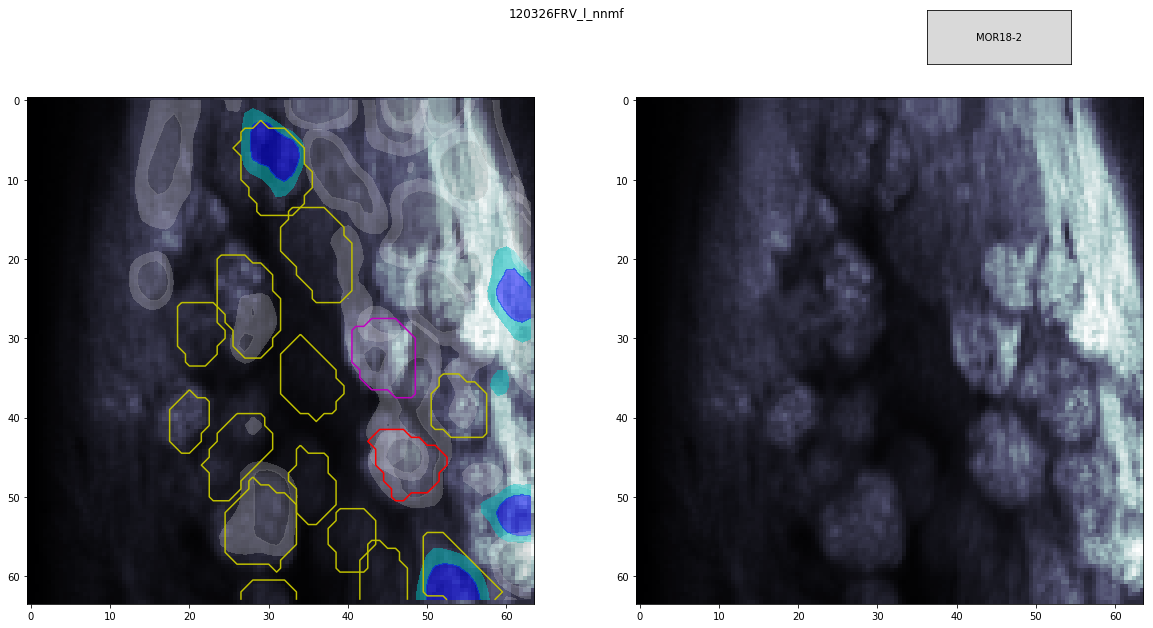

In [6]:
print("assign modes for method\n{}".format(method))
for animal in np.sort(animals):
    bg = plt.imread(os.path.join(bg_location, animal, 'bg.png'))
    
    rois = ia.TimeSeries()
    rois.load(os.path.join(bg_location, animal, 'rois')) 
    roicolor = defaultdict(lambda: 'y')
    roicolor[0] = 'r'
    roicolor[1] = 'm'
    roidict = {'data':rois, 'colors':roicolor}
    
    filename = glob.glob(os.path.realpath(os.path.join(data_location, animal, method+'.npy')))
    print filename
    assert len(filename)==1
    filename = filename[0].split('.')[0]
    ts = ia.TimeSeries()
    ts.load(filename)
    
    odor_response = ia.TrialMean()(ia.CutOut(stim_window)(ts))
    ts.t2t = ia.CalcStimulusDrive()(odor_response)._series.squeeze() 
      
    if (animal in alias_dict[method]):
        alias_method = alias_dict[method][animal]
    else:
        alias_method = {}
    selector = AssignMode({'mf':ts, 'bg':bg, 'alias':alias_method, 'roi':roidict})
    plt.show()
    if selector.alias:
        alias_dict[method][animal]=selector.alias
    elif animal in alias_dict[method]:
        alias_dict[method].pop(animal)

save the assignment

In [12]:
json.dump(alias_dict, open(aliasfile, 'w'))

### Summarize extracted modes for methods

In [7]:
for k, v in alias_dict.items():
    print '%s with %d identified MOR18-2 modes'%(k, len(v))

nnmf_20_sm5_convex_negTimelowSP_sp*_sph_meas with 12 identified MOR18-2 modes
nnmf_50_sm2_convex_negTimelowSP_sp*_sph_meas with 12 identified MOR18-2 modes


### Plot all extracted MOR18-2 modes

In [8]:
methods = alias_dict.keys()

for method in methods:
    fig = plt.figure(figsize=(20, 3*len(alias_dict[method])))
    gs = matplotlib.gridspec.GridSpec(len(alias_dict[method]),1, left=0.02, hspace=0.7, top=0.97, right=0.99)
    
    modecolors = ['g','b','c']
    for ix, animal in enumerate(np.sort(alias_dict[method].keys())):
        gs_inner = matplotlib.gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs[ix], width_ratios=(2,8))
        ax = fig.add_subplot(gs_inner[0])    
        bg = Image.open(os.path.join(bg_location, animal, 'bg.png'))
        bg = bg.convert('L')
        
        mf = ia.TimeSeries()
        filename = glob.glob(os.path.join(data_location, animal, method+'.npy'))
        assert len(filename) == 1
        filename = filename[0].split('.')[0]
        mf.load(filename)
        
        bg = bg.resize(mf.base.shape[::-1])
        bg = np.asarray(bg)
        
        mf = ia.SingleSampleResponse()(ia.TrialMean()(ia.CutOut(stim_window)(mf)))
        order_ix = np.argsort(mf.label_stimuli)
        mf = ia.SelectTrials()(mf, order_ix)
        
        myextent = np.array([0, mf.base.shape[1], mf.base.shape[0], 0])-0.5
        ax.imshow(bg, interpolation='none', extent=myextent, cmap=plt.cm.bone)
        for ix, base_ix in enumerate(alias_dict[method][animal]['MOR18-2']):
            ax.contour(mf.base.shaped2D()[base_ix], [-0.3,0.3,0.7], colors=['m']+2*[modecolors[ix]], lw=2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(animal)
        
        ax = fig.add_subplot(gs_inner[1])
        for ix, base_ix in enumerate(alias_dict[method][animal]['MOR18-2']):
            ax.plot(mf.matrix_shaped()[:,base_ix], color=modecolors[ix])
        ax.set_xticks(range(len(order_ix)))
        ax.set_xticklabels(mf.label_stimuli, rotation='45', ha='right', size=10)
        ax.set_xlim((-0.5,len(order_ix)-0.5))
        ax.set_yticks([0,0.5])
        
    fig.savefig(os.path.join(savepath182modes, 'sph_' + ''.join(method.split('*')) + '.pdf'))
    plt.close('all')

### Collect and norm 18-2 response spectra 

In [9]:
norm_to = '554-12-1' #'554-12-1' for Methyl propionate, None for unormed responses
response_thres = 0.2 #exclude all modes where response to norm_to is below this [promille]
skip = [] #animals to skip ('110623s' no undiluted odor)

Define function to clear stimuli labels. Thus it determines which stimuli are grouped together. Currently remove 'rechts'/'links' labels, as they correspond to syringe used. And '50grad' as there is no visible effect. Same with old label (marks an old sample of Acetaldehyde)

In [10]:
to_remove = ['rechts','links','re','li','50grad','old', 'o']

def clear_label(label):
    if '_' in label:
        label_split = label.split('_')
    for remove in set(to_remove).intersection(label_split):
        label_split.remove(remove)
    label = '_'.join(label_split)
    return label

calculate normed response spec

In [11]:
# load existing MOR18-2 spec
if os.path.exists(mor182specSPH_file):
    mor182spec = json.load(open(mor182specSPH_file))
else:
    mor182spec = {}

for method in alias_dict:
    print '=========== %s ============'%method
    response_dict = defaultdict(list)
    for ix, animal in enumerate(np.sort(alias_dict[method].keys())):
        if animal in skip: 
            continue
        
        mf = ia.TimeSeries()
        filename = glob.glob(os.path.join(data_location, animal, method+'.npy'))
        assert len(filename) == 1
        filename = filename[0].split('.')[0]
        mf.load(filename)
      
        mf.label_stimuli = [clear_label(i) for i in mf.label_stimuli]
        mf = ia.SingleSampleResponse()(ia.TrialMean()(ia.CutOut(stim_window)(mf)))        
      
        for ix, base_ix in enumerate(alias_dict[method][animal]['MOR18-2']):
            resp = mf._series[:,base_ix]
            # normieren
            if norm_to:
                if resp[mf.label_stimuli.index(norm_to)]>response_thres:
                    resp /= resp[mf.label_stimuli.index(norm_to)]
                    [response_dict[k].append(v) for k,v in zip(mf.label_stimuli, resp)]
                else:
                    print '%s: mode %d (of %d) excluded'%(animal,ix,len(alias_dict[method][animal]['MOR18-2']))
            else:
                [response_dict[k].append(v) for k,v in zip(mf.label_stimuli, resp)] 
    nameadd = 'normed' if norm_to else ''
    mor182spec[method+nameadd] = response_dict
json.dump(mor182spec, open(mor182specSPH_file, 'w'))

=========== nnmf_20_sm5_convex_negTimelowSP_sp*_sph_meas ============
120216FRVb: mode 0 (of 1) excluded
120222FRV: mode 0 (of 1) excluded
120223FRV: mode 0 (of 1) excluded
120315FRV: mode 0 (of 1) excluded
120325FRVil: mode 0 (of 1) excluded
=========== nnmf_50_sm2_convex_negTimelowSP_sp*_sph_meas ============
120216FRVb: mode 0 (of 1) excluded
120217FRVg: mode 0 (of 1) excluded
120223FRV: mode 0 (of 1) excluded
120325FRVil: mode 0 (of 1) excluded
120326FRV: mode 0 (of 1) excluded


## Plot spectra

In [12]:
method =  'nnmf_20_sm5_convex_negTimelowSP_sp*_sph_measnormed' #normed'
average_function = np.median

In [13]:
def condense_list_dict(dic, reducefct=np.mean):
    ''' apply reducefct to every value of dictionary'''
    reduced_dict = {}
    for k, v in dic.items():
        reduced_dict[k] = reducefct(v)
    return reduced_dict

#### Select relevant odors and sort according to avarage strength

In [14]:
pure_odors = [o for o in mor182spec[method].keys() if (len(o.split('_'))<2)]
pure_odor_resp = [average_function(mor182spec[method][o]) for o in pure_odors]
odors_sorted = [pure_odors[i] for i in np.argsort(pure_odor_resp)]
spec = [average_function(mor182spec[method][i]) for i in odors_sorted]

#### Calculate significance of response to Argon ('7440-37-1') and 2M2P ('623-36-9')

In [15]:
test = scipy.stats.mannwhitneyu#scipy.stats.ttest_ind #

p_val_argon = np.array([test(mor182spec[method]['7440-37-1'], mor182spec[method][i]) for i in odors_sorted])[:,1]
p_val_argon[np.isnan(p_val_argon)] = 1
p_val_argon[p_val_argon>0.05] = 1

p_val_2m2p = np.array([test(mor182spec[method]['623-36-9'], mor182spec[method][i]) for i in odors_sorted])[:,1]
p_val_2m2p[np.isnan(p_val_2m2p)] = 1
p_val_2m2p[p_val_2m2p>0.05] = 1

load odor names

In [16]:
cas2name = {l[0]:l[1] for l in csv.reader(open(os.path.join(datadict_path,'Name2MomCas.tab')),  delimiter='\t')}

#### Create figure

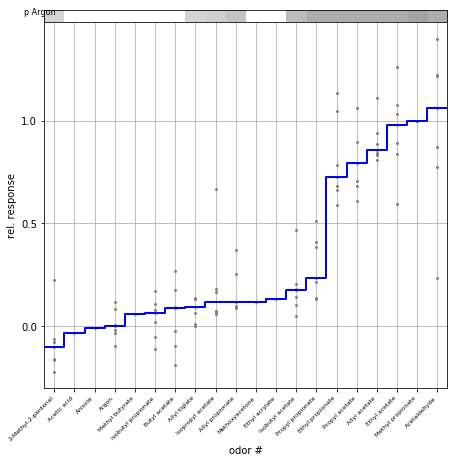

In [17]:
fig = plt.figure(figsize=(7,7))

gs = matplotlib.gridspec.GridSpec(2,1, bottom=0.2, top=0.95, left=0.15, right=0.95, height_ratios=[1,30], hspace=0)

num_odors = len(spec)

ax = fig.add_subplot(gs[0])
ax.imshow(-np.log10(p_val_argon).reshape((1,-1)), plt.cm.binary, interpolation='none', aspect='auto', vmax=9.2)
ax.set_xlim((-0.5, num_odors-0.5))
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('p Argon', rotation='0', size=8)

ax = fig.add_subplot(gs[1])
# individual measurements
for ix, mol in enumerate(odors_sorted):
    ax.plot(ix, np.array(mor182spec[method][mol]).reshape((1,-1)), '.', mec='none', mfc='0.5')

#average activation
ax.step(np.arange(num_odors+1)-0.5, [spec[0]]+spec, 'b', lw=2)

#decorate
ax.set_xticks(np.arange(num_odors))
ax.set_xticklabels([cas2name[m].decode("utf8") for m in odors_sorted], rotation='45', ha='right', size=6)
#ax.set_xticks(np.arange(0,num_odors,len(spec)/4))
#ax.set_xticks([odors_sorted.index(i) for i in ['623-36-9', '7440-37-1',]], minor=True)
#ax.set_xticklabels(['2M2P','Argon'], minor=True, size=8, rotation='45', ha='right')

ax.set_xlim((-0.5, num_odors-0.5))
ax.set_yticks([0,0.5,1])
ax.grid()
ax.set_ylabel('rel. response')
ax.set_xlabel('odor #')

fig.savefig(os.path.join(savepath182spec, 'sph_'+''.join(method.split('*'))+'.pdf'))

plt.show()

### Compare SPH to IOS response

In [18]:
methodIOS =  'nnmf_200_sm2_convex_negTimelowSP_sp*_ios_measnormed'
mor182specIOS = json.load(open(mor182specIOS_file))

#Get response for odors included in SPH measurements
IOSspec = [average_function(mor182specIOS[methodIOS][o]) for o in odors_sorted]

#mask to exclude odors with less than 3 IOS measurements
num_IOS = [len(mor182specIOS[methodIOS][o]) for o in odors_sorted]
mask = np.array(num_IOS)>3

#### Isotonic Regression

In [19]:
iso_r = IsotonicRegression()
iso_r.fit(np.array(spec)[mask], np.array(IOSspec)[mask])

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None,
          y_min=None)

/home/micha/anaconda2/envs/mol23/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function X_ is deprecated; Attribute ``X_`` is deprecated in version 0.18 and will be removed in version 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/home/micha/anaconda2/envs/mol23/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function y_ is deprecated; Attribute ``y_`` is deprecated in version 0.18 and will be removed in version 0.20.
  warnings.warn(msg, category=DeprecationWarning)


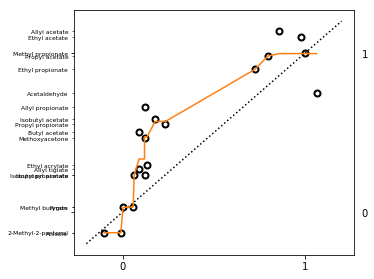

In [20]:
fig = plt.figure()
ax = fig.add_axes([0.3,0.1,0.65,0.85])
ax.plot(np.array(spec)[mask], np.array(IOSspec)[mask], 'o', mfc='none', mec='k', mew=2)
ax.plot([-0.2,1.2],[-0.2,1.2],':k')
ax.plot(iso_r.X_, iso_r.y_)
ax.set_xticks([0,1])
ax.set_yticks(np.array(IOSspec)[mask], minor=True)
ax.set_yticklabels([cas2name[odors_sorted[i]].decode("utf8") for i in np.where(mask)[0]], size=6, minor=True)
ax.yaxis.set_tick_params(label2On=True, label1On=False)
ax.set_yticks([0,1])
#ax.yaxis.set_tick_params(label1On=True)
plt.show()

In [21]:
print 'rank correlation %.2f, p=%.5f'%scipy.stats.spearmanr(np.array(spec)[mask], np.array(IOSspec)[mask])

rank correlation 0.92, p=0.00000
